In [1]:
from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
NROWS = 200_000

In [2]:
md = load_md_from_file(path=PATH_TO_FILE, nrows=NROWS)

In [3]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = Sim(md, latency, md_latency)

In [4]:
#delay between orders
delay = pd.Timedelta(0.1, 's').delta

hold_time = pd.Timedelta(10, 's').delta

strategy = BestPosStrategy(delay, hold_time)

In [5]:
%time trades_list, md_list, updates_list, all_orders = strategy.run(sim)

CPU times: user 13.1 s, sys: 17.1 ms, total: 13.1 s
Wall time: 13.1 s


In [6]:
%time df = get_pnl(updates_list)

CPU times: user 566 ms, sys: 4.58 ms, total: 571 ms
Wall time: 570 ms


In [7]:
df

,exchange_ts,receive_ts,total,BTC,USD,mid_price
0,1655942402249000000,1655942402250125991,0.00000,0.000,0.0000,19977.45
1,1655942402623000000,1655942402624789714,0.00000,0.000,0.0000,19977.45
2,1655942402623000000,1655942402633000000,0.00005,-0.001,19.9775,19977.45
3,1655942402655000000,1655942402657844605,0.00005,-0.001,19.9775,19977.45
4,1655942403346000000,1655942403346968722,0.00005,-0.001,19.9775,19977.45
...,...,...,...,...,...,...
503580,1655949385324000000,1655949385324623531,-252.48755,0.911,-18803.8638,20363.75
503581,1655949385358000000,1655949385358833098,-252.48755,0.911,-18803.8638,20363.75
503582,1655949385391000000,1655949385391916170,-252.48755,0.911,-18803.8638,20363.75
503583,1655949385424000000,1655949385424604016,-252.48755,0.911,-18803.8638,20363.75


In [8]:
dt = pd.to_datetime(df.receive_ts)

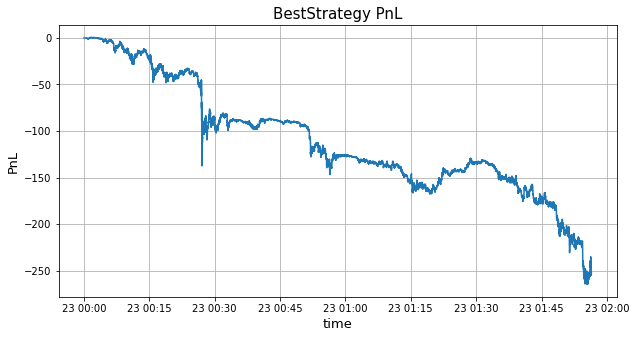

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()

In [10]:
from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import merge_books_and_trades


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [11]:
from simulator import MdUpdate, OrderbookSnapshotUpdate, AnonTrade

from get_info import md_to_dataframe, trade_to_dataframe

In [12]:
def generate_sample_data_1(n_points):
    '''
        this function generates market data with constant mid price and occasional trades
    '''
    mid_price = 100.0
    spread = 2.0
    bid_price = mid_price - spread / 2
    ask_price = mid_price + spread / 2
    size = 1
    
    books = [OrderbookSnapshotUpdate(2 * i, 2 * i, [(ask_price, size)], [(bid_price, size)]) for i in range(1) ]
    
    trades = []
    p = 0.25
    trade_id = np.random.choice([0, 1], size=n_points, p=[1-p, p])
    trade_id = [i % 5 == 0 for i in range(n_points)]
    for i in range(n_points):
        
        if trade_id[i]:
            
            side = np.random.choice([0, 1], size=1)[0]
            price = bid_price if side else ask_price
            side = "ASK" if side else "BID" 
            trade = AnonTrade(2 * i + 1, 2 * i + 1, side, size, price)
            trades.append(trade)

    return books, trades

In [13]:
def generate_sample_data_2(n_points):
    '''
        this function generates market data with lineary increasing mid price and 
        limit orders at the same distance from the mid price
    '''   
    mid_price = 100.0
    spread = 2.0
    bid_price = mid_price - spread / 2
    ask_price = mid_price + spread / 2
    size = 1
    
    books = []
    
    
    trades = []
    p = 0.5
    for i in range(n_points):
        
        bid_price = mid_price - spread / 2
        ask_price = mid_price + spread / 2
        
        book = OrderbookSnapshotUpdate(i, i, [(ask_price, size)], [(bid_price, size)])
        books.append( book  )
        mid_price += 1
    return books, trades

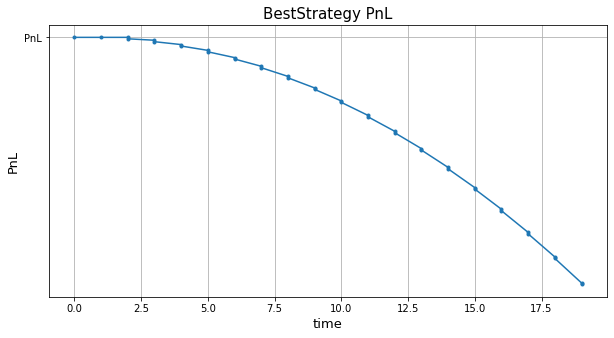

In [14]:
books, anon_trades = generate_sample_data_2(20)

md = merge_books_and_trades(books, anon_trades)

latency = pd.Timedelta(0, 'ns').delta
md_latency = pd.Timedelta(0, 'ns').delta
sim = Sim(md, latency, md_latency)

#delay between orders
delay = pd.Timedelta(1, 'ns').delta
hold_time = pd.Timedelta(1000, 'ns').delta
strategy = BestPosStrategy(delay, hold_time)

own_trades, md_list, updates_list, all_orders = strategy.run(sim)

df_info = get_pnl(updates_list)
t = df_info.receive_ts.values

plt.figure(figsize=(10, 5))
plt.plot(t, df_info.total, '.-', 'PnL')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)

plt.title("BestStrategy PnL", fontsize=15)
plt.grid()
plt.show()

In [15]:
updates_list

[MdUpdate(exchange_ts=0, receive_ts=0, orderbook=OrderbookSnapshotUpdate(exchange_ts=0, receive_ts=0, asks=[(101.0, 1)], bids=[(99.0, 1)]), trade=None),
 MdUpdate(exchange_ts=1, receive_ts=1, orderbook=OrderbookSnapshotUpdate(exchange_ts=1, receive_ts=1, asks=[(102.0, 1)], bids=[(100.0, 1)]), trade=None),
 MdUpdate(exchange_ts=2, receive_ts=2, orderbook=OrderbookSnapshotUpdate(exchange_ts=2, receive_ts=2, asks=[(103.0, 1)], bids=[(101.0, 1)]), trade=None),
 OwnTrade(place_ts=0, exchange_ts=2, receive_ts=2, trade_id=0, order_id=1, side='ASK', size=0.001, price=101.0, execute='BOOK'),
 MdUpdate(exchange_ts=3, receive_ts=3, orderbook=OrderbookSnapshotUpdate(exchange_ts=3, receive_ts=3, asks=[(104.0, 1)], bids=[(102.0, 1)]), trade=None),
 OwnTrade(place_ts=1, exchange_ts=3, receive_ts=3, trade_id=1, order_id=3, side='ASK', size=0.001, price=102.0, execute='BOOK'),
 MdUpdate(exchange_ts=4, receive_ts=4, orderbook=OrderbookSnapshotUpdate(exchange_ts=4, receive_ts=4, asks=[(105.0, 1)], bids=[

In [16]:
all_orders

[Order(place_ts=0, exchange_ts=0, order_id=0, side='BID', size=0.001, price=99.0),
 Order(place_ts=0, exchange_ts=0, order_id=1, side='ASK', size=0.001, price=101.0),
 Order(place_ts=1, exchange_ts=1, order_id=2, side='BID', size=0.001, price=100.0),
 Order(place_ts=1, exchange_ts=1, order_id=3, side='ASK', size=0.001, price=102.0),
 Order(place_ts=2, exchange_ts=2, order_id=4, side='BID', size=0.001, price=101.0),
 Order(place_ts=2, exchange_ts=2, order_id=5, side='ASK', size=0.001, price=103.0),
 Order(place_ts=3, exchange_ts=3, order_id=6, side='BID', size=0.001, price=102.0),
 Order(place_ts=3, exchange_ts=3, order_id=7, side='ASK', size=0.001, price=104.0),
 Order(place_ts=4, exchange_ts=4, order_id=8, side='BID', size=0.001, price=103.0),
 Order(place_ts=4, exchange_ts=4, order_id=9, side='ASK', size=0.001, price=105.0),
 Order(place_ts=5, exchange_ts=5, order_id=10, side='BID', size=0.001, price=104.0),
 Order(place_ts=5, exchange_ts=5, order_id=11, side='ASK', size=0.001, price

In [17]:
sim.ready_to_execute_orders

{0: Order(place_ts=0, exchange_ts=0, order_id=0, side='BID', size=0.001, price=99.0),
 2: Order(place_ts=1, exchange_ts=1, order_id=2, side='BID', size=0.001, price=100.0),
 4: Order(place_ts=2, exchange_ts=2, order_id=4, side='BID', size=0.001, price=101.0),
 6: Order(place_ts=3, exchange_ts=3, order_id=6, side='BID', size=0.001, price=102.0),
 8: Order(place_ts=4, exchange_ts=4, order_id=8, side='BID', size=0.001, price=103.0),
 10: Order(place_ts=5, exchange_ts=5, order_id=10, side='BID', size=0.001, price=104.0),
 12: Order(place_ts=6, exchange_ts=6, order_id=12, side='BID', size=0.001, price=105.0),
 14: Order(place_ts=7, exchange_ts=7, order_id=14, side='BID', size=0.001, price=106.0),
 16: Order(place_ts=8, exchange_ts=8, order_id=16, side='BID', size=0.001, price=107.0),
 18: Order(place_ts=9, exchange_ts=9, order_id=18, side='BID', size=0.001, price=108.0),
 20: Order(place_ts=10, exchange_ts=10, order_id=20, side='BID', size=0.001, price=109.0),
 22: Order(place_ts=11, exchan